# Assignment 4

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist

# Problem 2: Gaussian Linear Dynamical System

In [227]:
a = 1.; b = 0.
q= 0.1; r= 0.3
T = 30

# -----------------------------------
trange = np.arange(T)

# Sample from Gaussian LDS
x = np.empty(T); y = np.empty(T)
for t in trange:
    x[t] = npr.normal(a*x[t-1], q**2) if t!= 0 else npr.normal(0,q**2)
    y[t] = npr.normal(x[t], r**2)
    
# Compute filtered distribution p(x_t | y_{1:t})
m = np.empty(T); v = np.empty(T)
for t in trange:
    p = (q**2 + (a**2)*v[t-1]) if t!=0 else q**2
    m1 = m[t-1] if t!=0 else 0
    k = p / (p + r**2)
    v[t] = (1-k) * p
    m[t] = m1 + k*(y[t]-m1)

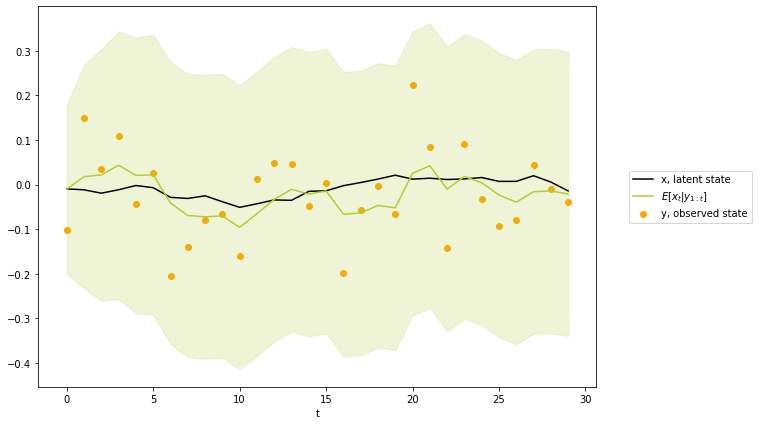

In [231]:
plt.figure(figsize=(10,7))

# Plot true latent state
plt.plot(trange, x, 'k-', label='x, latent state')

# Plot observations
plt.scatter(trange, y, color='orange', marker='o', label='y, observed state')

# Plot mean of forward filtered distribution and error bars
plt.plot(trange, m, color = (0.7,0.8,0.2, 1), label='$E[x_t | y_{1:t}]$')
plt.fill_between(trange, m-2*np.sqrt(v), m+2*np.sqrt(v), color = (0.7,0.8,0.2,0.2))

# Plot mean of forward filtered distribution and error bars
# plt.plot(trange, m2, color = (0.4,0.4,0.4, 1))
# plt.fill_between(trange, m2-2*np.sqrt(v2), m2+2*np.sqrt(v2), color = (0.4,0.4,0.4,0.2))


plt.xlabel('t')
plt.legend(loc='center left', bbox_to_anchor=[1.05, 0.5])

# Problem 3: Gaussian Process with Squared Exponential Function

In [116]:
# Squared error kernel
def kernel_SE(xp, xq, hparams):
    """
    Calculates the exponentiated squared euclidean distance between two vectors, possible of unequal length
    This is pretty much how sklearn.gaussian_process.kernels.RBF is implemented, but I just wanted to check it out
    
    Inputs:
        xp          Input vector, size (num_p, num_samples)
        xq          Input vector, size (num_q, num_samples)
        hparams       Dictionary of hyperparameter values containing
                    - length   Length scale, determines smoothness/periodicity of kernel
                    - sigmaf   Kernal scale, determines average distance that fxn. is away from the mean
    Ouputs:
        Returns array of (num_p, num_q)
    """
    # Input vectors must be at least 2d in order to calculate collection pairwise distances
    if xp.ndim == 1: xp = xp.reshape(-1,1)
    if xq.ndim == 1: xq = xq.reshape(-1,1)
    
    length = hparams['length'] if 'length' in hparams else 1
    sigmaf = hparams['sigmaf'] if 'sigmaf' in hparams else 1    
    
    # Calculate length-scaled pairwise distances between the two vectors
    dpq = cdist(xp / length, xq / length, metric='sqeuclidean')
    
    return sigmaf**2 * np.exp(-.5 * dpq)

In [117]:
# Generate Gaussian process
def simulate_GP(x, N, k_func, hparams):
    """
    Produces samples of multivariate normal process with
    zero mean and squared exponential kernal function
    
    Inputs:
        num_samples   Number of samples to generate
        hparams       Dictionary of hyperparameter values for calculating kernel, contains
                        - sigman, additive covariance noise
    Outputs:
        data          (x,y) tuple
        params        Mean and covaraince functions used to generate data
    """
    # Calculate mean and covariance functions
    sigman = hparams['sigman'] if 'sigman' in hparams else 0
    m = np.zeros(N)
    K = k_func(x,x,hparams) + sigman*np.eye(N) # Shape: (N,N)
    
    # Sample from specified normal distribution
    y = npr.multivariate_normal(m, K)
    
    return (x,y), (m,K)

Text(0.5, 1.0, 'Simulated data drawn from GP with params $(\\ell, \\sigma_f, \\sigma_n) = (1.0,1.0,0.1)$')

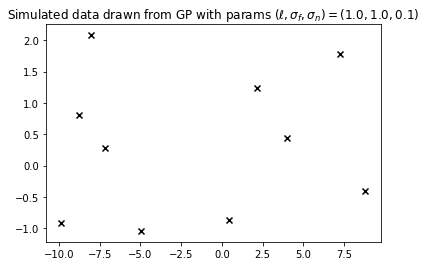

In [199]:
# Generate random set of input locations in this pre-specified range
N = 10

x = npr.uniform(-10, 10, N)    
hparams = {'length': 1, 'sigmaf': 1, 'sigman': 0.1}

data, params = simulate_GP(N, kernel_SE, hparams)

# Plot simulated points

plt.scatter(data[0], data[1], marker = 'x', color='k')
plt.title('Simulated data drawn from GP with params $(\ell, \sigma_f, \sigma_n) = (%.1f,%.1f,%.1f)$'
          %(hparams['length'], hparams['sigmaf'], hparams['sigman'])) 

## Predict functions based off of observations

In [200]:
def predict_GP(x_test, data, k_func, hparams):
    x_obs, y_obs = data
    N = x_obs.size
    
    # Compute each kernel function
    sigman = hparams['sigman'] if 'sigman' in hparams else 0
    K_XX = k_func(x_obs,x_obs,hparams) + sigman*np.eye(N)
    K_XXs = k_func(x_obs, x_test, hparams) # == k_func(x_test,x_obs, hparams).T
    K_XsXs = k_func(x_test,x_test, hparams)
        
    # RW Eqn. (2.23): Mean function of conditional predictive distribution 
    m_test = K_XXs.T @ (np.linalg.solve(K_XX, y_obs))
    K_test = K_XsXs - K_XXs.T@np.linalg.solve(K_XX, K_XXs)
    
    return (m_test, K_test), x_test

In [201]:
def plot_GP_and_obs(data, params, xparams, hparams, ax=None):
    """
    Plots GP specified by params (m, K) with 2 standard dev error bar against scatter plot of data points
    """
    x, y = data
    m, K = params
    sigma = np.sqrt(np.diag(K))
    
    if ax is None: ax=plt.gca()
    if xparams is None: xparams = x
    
    ax.scatter(x, y, marker = 'x', color='k')
    ax.plot(xparams, m, color = (0.7,0.8,0.2, 1))
    ax.fill_between(xparams, m-2*sigma, m+2*sigma, color = (0.7,0.8,0.2,0.2))
    ax.set_title('Params $(\ell, \sigma_f, \sigma_n) =$ (%.2f,%.2f,%.2f)'%(hparams['length'], hparams['sigmaf'], hparams['sigman'])) 
    return ax

Text(0.5, 0.98, 'Predicted GP results against observations')

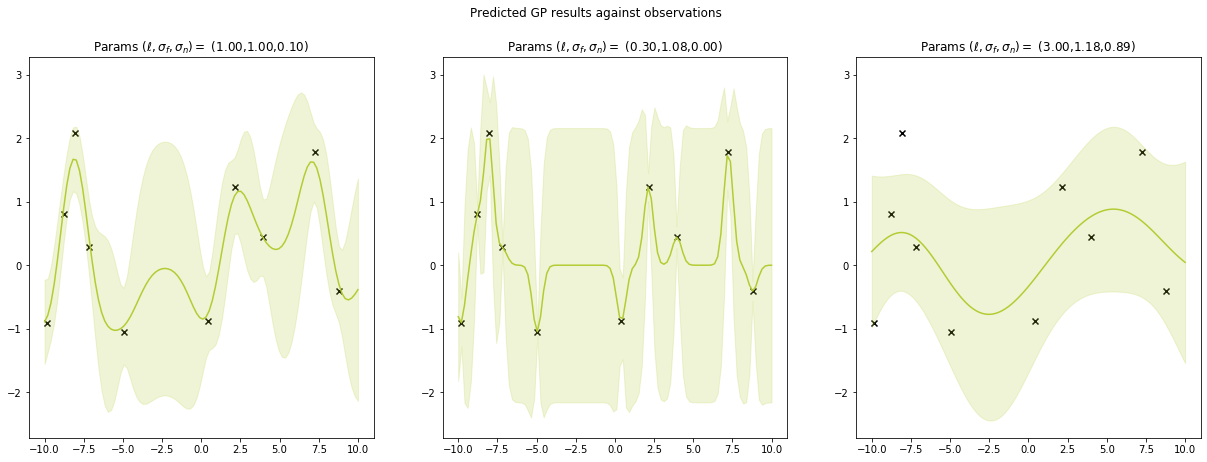

In [202]:
fig = plt.figure(figsize=(21,7))

# --------------------------------
# (1, 1, 0.1): "standard case", also the params that we simulated with
# --------------------------------
hparams_test = {'length': 1, 'sigmaf': 1, 'sigman': 0.1}
params_pred, x_pred = predict_GP(data, kernel_SE, hparams_test)

ax1 = fig.add_subplot(131)
plot_GP_and_obs(data, params_pred, x_pred, hparams_test, ax1)

# ----------------------------------------------
# (0.3, 1.08, 0.00005): High frequency fitting
# ----------------------------------------------
hparams_test = {'length': 0.3, 'sigmaf': 1.08, 'sigman': 0.00005}
params_pred, x_pred = predict_GP(data, kernel_SE, hparams_test)

ax2 = fig.add_subplot(132, sharey=ax1)
plot_GP_and_obs(data, params_pred, x_pred, hparams_test, ax2)


# ----------------------------------------------
# (3.0, 1.18, 0.89): Smoothing/low-frequency fitting
# ----------------------------------------------
hparams_test = {'length': 3, 'sigmaf': 1.18, 'sigman': 0.89}
params_pred, x_pred = predict_GP(data, kernel_SE, hparams_test)

ax3 = fig.add_subplot(133, sharey=ax1)
plot_GP_and_obs(data, params_pred, x_pred, hparams_test, ax3)

plt.suptitle('Predicted GP results against observations')